# Using this notebook
* You have to execute this notebook by running each cell consecutively.
* To retain any changes made, you need to save the notebook.

For detailed information about the notebook interface see _Help -> User Interface Tour_ in the menu, and the [Guidebook](https://lbologna.github.io/hbp-sp6-guidebook/getting_started/getting_started.html#working-with-collabs) for working with Collabs.

# Simulate calcium influx into a synapse stochastically
__Aim:__ This use case shows how to use [KappaNEURON](https://github.com/davidcsterratt/KappaNEURON) to simulate calcium influx into a synapse, and demonstrates the principles of how it works.

__Version:__ 1.1 (July 2019)

__Contributors:__ David Sterratt (UEDIN, Edinburgh, Scotland)

__Contact:__ david.c.sterratt@ed.ac.uk

## 0. Introduction

KappaNEURON integreates a *rule-based* simulator called SpatialKappa into NEURON. Rule-based languages such as Kappa or BNGL allow models containing molecular interactions, such as binding of protein domains, and modifications, such as phosphorolation, to be described compactly, using a syntax akin to chemical reactions. Simulators such as KaSim or SpatialKappa (for Kappa) or NFSim or RuleBender (BNGL) interpret rule-based models stochastically, producing simulations of the molecular complexes over time.

A full description of KappaNEURON is available in this paper: Sterratt, D. C., Sorokina, O. and Armstrong, J. D. (2015). ‘Integration of rule-based models and compartmental models of neurons’. Lecture Notes in Bioinformatics 7699: 143-158. Presented to the Third International Workshop on Hybrid Systems Biology Vienna, Austria, July 23-24, 2014 at the International Conference on Computer-Aided Verification 2014. doi:10.1007/978-3-319-27656-4_9. Preprint at arXiv:1411.4980

### 0.1 Installation

KappaNEURON can be installed via pip, as shown in this notebook. 
The KappaNEURON sources are at
https://github.com/davidcsterratt/KappaNEURON

### 0.2 Overview of the simulation

In this simulation we will use Kappa to model a calcium extrusion pump in a spine head modelled by a single compartment in NEURON. The pump model is contained in the file `caPump2.ka`. The lines describing the rules are:
```
%agent: ca(x)
%agent: P(x)
'ca binding' ca(x), P(x)     -> ca(x!1), P(x!1) @ 'k1' * 'agconc'
'ca release' ca(x!1), P(x!1) -> P(x)            @ 'k2'
```
The first two lines define calcium `ca` and a pump molecule `P` as *agents*, each with a binding *site* `x`. The third line describes binding of the `x` site of `ca` to the `x` site of  `P` via a *link*, denoted `!1`. The rate of this rule is given by the product of two variables `k1` and `agconc`. The fourth line describes the unbinding of calcium and the pump molecule, at a rate `k2`.

# 1. Collab-specific set-up

## 1.1 Java
There is no Java installation on the Collab, so we need to install it specially.

In [1]:
import os
javabindir = os.path.join(os.environ["HOME"], "jdk-10.0.2", "bin")
if not os.path.exists(javabindir):
    !cd
    !wget -nc https://download.java.net/java/GA/jdk10/10.0.2/19aef61b38124481863b1413dce1855f/13/openjdk-10.0.2_linux-x64_bin.tar.gz
    !tar xf openjdk-10.0.2_linux-x64_bin.tar.gz
os.environ["PATH"] = os.environ["PATH"] + ":" + javabindir

## 1.2 KappaNEURON

In [2]:
!pip install --quiet KappaNEURON==0.3.2

## 1.3. Move files from storage to working space 
We need to move files from collab storage to local storage.

In [3]:
# Name of simulation
simname = 'demo_ca_pulse'
# Name of directory to store simulations in locally
simsdir = os.path.join(os.environ["HOME"], 'KappaNEURON-sims')
# Name of local directory for this simulation
simdir = os.path.join(simsdir, simname)
# Create local directory, if it doesn't exist
if not os.path.exists(simsdir):
        os.mkdir(simsdir)

# Get the files from collab storage
import zipfile
print("Connecting to storage...")
client = get_bbp_client().document
COLLAB_PATH = "2184"
simzipfile = simname + '.zip'
if not os.path.exists(simzipfile):
    print("Getting file " + simzipfile)
    client.download_file(os.path.join(COLLAB_PATH, simzipfile),
                         os.path.join(simsdir, simzipfile))
print("Extracting files...")
zf = zipfile.ZipFile(os.path.join(simsdir, simzipfile))
zf.extractall(simsdir)
print(os.listdir(simdir))

Connecting to storage...
Getting file demo_ca_pulse.zip
Extracting files...
['capulse.mod', 'caPump2.mod', 'caPump2.ka']


# 2. Compile mod files
Some of these files are mod files, which need to be compiled as usual for a NEURON simulation

In [4]:
os.chdir(simdir)
!nrnivmodl

Creating x86_64 directory for .o files.

/home/jovyan/KappaNEURON-sims/demo_ca_pulse
caPump2.mod capulse.mod
caPump2.mod capulse.mod
"/usr/local/nrn/x86_64/bin/nocmodl" caPump2
Translating caPump2.mod into caPump2.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o caPump2.lo caPump2.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c caPump2.c  -fPIC -DPIC -o .libs/caPump2.o
"/usr/local/nrn/x86_64/bin/nocmodl" capulse
Translating capulse.mod into capulse.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o capulse.lo capulse.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c capulse.c  -fPIC -DPIC -o .

# 3. Simulation code
NEURON is imported as usual, but we also imoprt KappaNEURON and the rxd (reaction-diffusion) module from NEURON.

In [5]:
from neuron import *
import KappaNEURON
from neuron import rxd
import matplotlib.pyplot as plt

Create a spine head `sh` with a passive channel.

In [6]:
sh = h.Section()
sh.L = 0.1
sh.diam = 0.2
sh.insert('pas')

Set up a calcium pulse that lasts from 5ms to 10ms. The GHK equations are used to generate the current based on intra- and extracellular calcium concentrations.

In [7]:
sh.insert('capulse')
sh.gbar_capulse = 0.001
sh.fghk_capulse = 1         # Use GHK
sh.t0_capulse = 5
sh.t1_capulse = 10

Here the link between the NEURON and Kappa simulators is made. First the spine head section `sh` needs to be connected to a *region* `r` in the `rxd` module. Then `rxd` *species* with __names corresponding to those in the Kappa file__ will be created, i.e. `ca` (calcium) and `P` (a pump molecule). Finally the Kappa simulation is started, with arguments linking together:
* the file `caPump2.ka`, which contains the molecular model defined in the Kappa language
* the species `ca` and `P` that we have just created
* the region `r` that we have just created

Because calcium crosses the membrane, `ca` is a `membrane_species`. Because the pump module `P` does not cross the membrane it is a plain `species`. The region specificiation `r` means only to make the link in this region.

In [8]:
## Define region where the dynamics will occur ('i' means intracellular)
r = rxd.Region([sh], nrn_region='i')

## Define the species, the ca ion (already built-in to NEURON), and
## the pump molecule. These names must correspond to the agent names
## in the Kappa file.
ca = rxd.Species(r, name='ca', charge=2, initial=0.0) # calcium
P  = rxd.Species(r, name='P',  charge=0, initial=0.2) # pump module

## Create the link between the Kappa model and the species just defined
kappa = KappaNEURON.Kappa(membrane_species=[ca], species=[P],
kappa_file='caPump2.ka', regions=[r])

`k1` and `k2`, the forward and backward rates of the pump (with units mM<sup>-1</sup>ms<sup>-1</sup> and ms<sup>-1</sup> respectively), are defined as varibles in `caPump2.ka` using the `%var` declaration. Their values can now be overridden using the `setVariable()` function of the `KappaNEURON` object just created.

In [9]:
## Transfer variable settings to the kappa model
kappa.setVariable('k1', 47.3)
kappa.setVariable('k2', 0.1)

The Kappa file does not have access to all variables in NEURON, so we set the nominal volume of the spine head by passing a variable `vol` to the Kappa simulation. This is then used in the Kappa file to set the forward reaction rate of `ca` binding to `P`, which has the units of ms<sup>-1</sup>.

In [10]:
## Volume needs to be specified explicitly
vol = sh.L*numpy.pi*(sh.diam/2)**2
kappa.setVariable('vol', vol)

The rest of the simulation now looks like standard NEURON. We set up  recordings. Note that the intracellular concentration of the unbound `P` molecule is referred to as `Pi`, analogous to `cai`.

In [11]:
## Record Time from NEURON (neuron.h._ref_t)
rec_t = h.Vector()
rec_t.record(h._ref_t)
## Record Voltage from the center of the soma
rec_v = h.Vector()
rec_v.record(sh(0.5)._ref_v)
## Record ica from spine head
rec_ica = h.Vector()
rec_ica.record(sh(0.5)._ref_ica)
## Record Ca from spine head
rec_cai = h.Vector()
rec_cai.record(sh(0.5)._ref_cai)
## Record P from spine head
rec_Pi = h.Vector()
rec_Pi.record(sh(0.5)._ref_Pi)

1.0

We now run the simulation, with the extra finitialize line. The progress is shown. At the start of every NEURON `dt`, the *expected* calcium current generated by the `capulse` is passed to the Kappa simulator. Kappa then runs for `dt`, creating calcium ions one by one according to a Poisson process with the rate determined by the calcium current.  Kappa then feeds back the *actual* number of calcium ions created in the `dt` step back to NEURON, which then runs for its `dt`, ensuring that the change in the membrane potential is commensurate with the number of ions created by Kappa.

In [12]:
init()
h.finitialize(sh.e_pas)
run(30)

Time =     30.00000/30.00000 [100.000%]


The plots show the current flowing in during the pulse. As it starts to flow in the calcium concentration rises, and the amount of free pump molecule goes down, as some of the calcium binds to it. After the end of the pulse, calcium is released from the pump molecule and expelled through the membrane, leading to an outward current that hyperpolarises the cell.

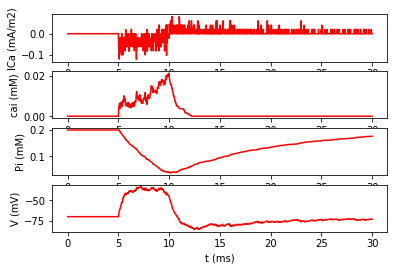

In [13]:
fig, ax = plt.subplots(nrows=4, ncols=1)
ax[0].plot(numpy.array(rec_t), numpy.array(rec_ica), 'r')
ax[0].set_ylabel('ICa (mA/m2)')
ax[1].plot(numpy.array(rec_t), numpy.array(rec_cai), 'r')
ax[1].set_ylabel('cai (mM)')
ax[2].plot(numpy.array(rec_t), numpy.array(rec_Pi), 'r')
ax[2].set_ylabel('Pi (mM)')
ax[3].plot(numpy.array(rec_t), numpy.array(rec_v), 'r')
ax[3].set_ylabel('V (mV)')
ax[3].set_xlabel('t (ms)')